# Differences in CModel fits between old SDSS deblender and new scarlet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from lsst.daf.persistence import Butler
from lsst.afw.image import Image, MultibandImage, MultibandExposure
from lsst.afw.detection import MultibandFootprint
from lsst.geom import SpherePoint, degrees, radians
from showMultibandImage import showRGB
from makeCutout import cutout_HST
from astropy.visualization import AsinhStretch, ImageNormalize

## Load demo data from a tiny (0.5kx0.5k) patch

In [2]:
path = "/datasets/hsc/repo/rerun/private/yusra/deblender-sprint"
subdir = "w_2019_18_05k"
butlerBase = Butler(os.path.join(path, subdir))
scarletMeasTypes = {'noSym': '_noSym_demo'} # 'sym': '' (too many failed)
butlersScarlet = {key: Butler(os.path.join(path, "scarlet", subdir + suffix)) for key, suffix in scarletMeasTypes.items()}

In [3]:
skymap = butlerBase.get("deepCoadd_skyMap")
tract = 9813
patch = (17, 17)
patchname = ','.join([str(idx) for idx in patch])
dataId = {"tract": 9813, "patch": patchname}
filters = "grizy"
namesFilters = ["HSC-" + f.upper() for f in filters]

In [4]:
coadds = [butlerBase.get("deepCoadd_calexp_sub", dataId, filter=f,
                     bbox=skymap[tract][patch[0], patch[1]].getOuterBBox()) for f in namesFilters]
coadds = MultibandExposure.fromExposures(filters, coadds)

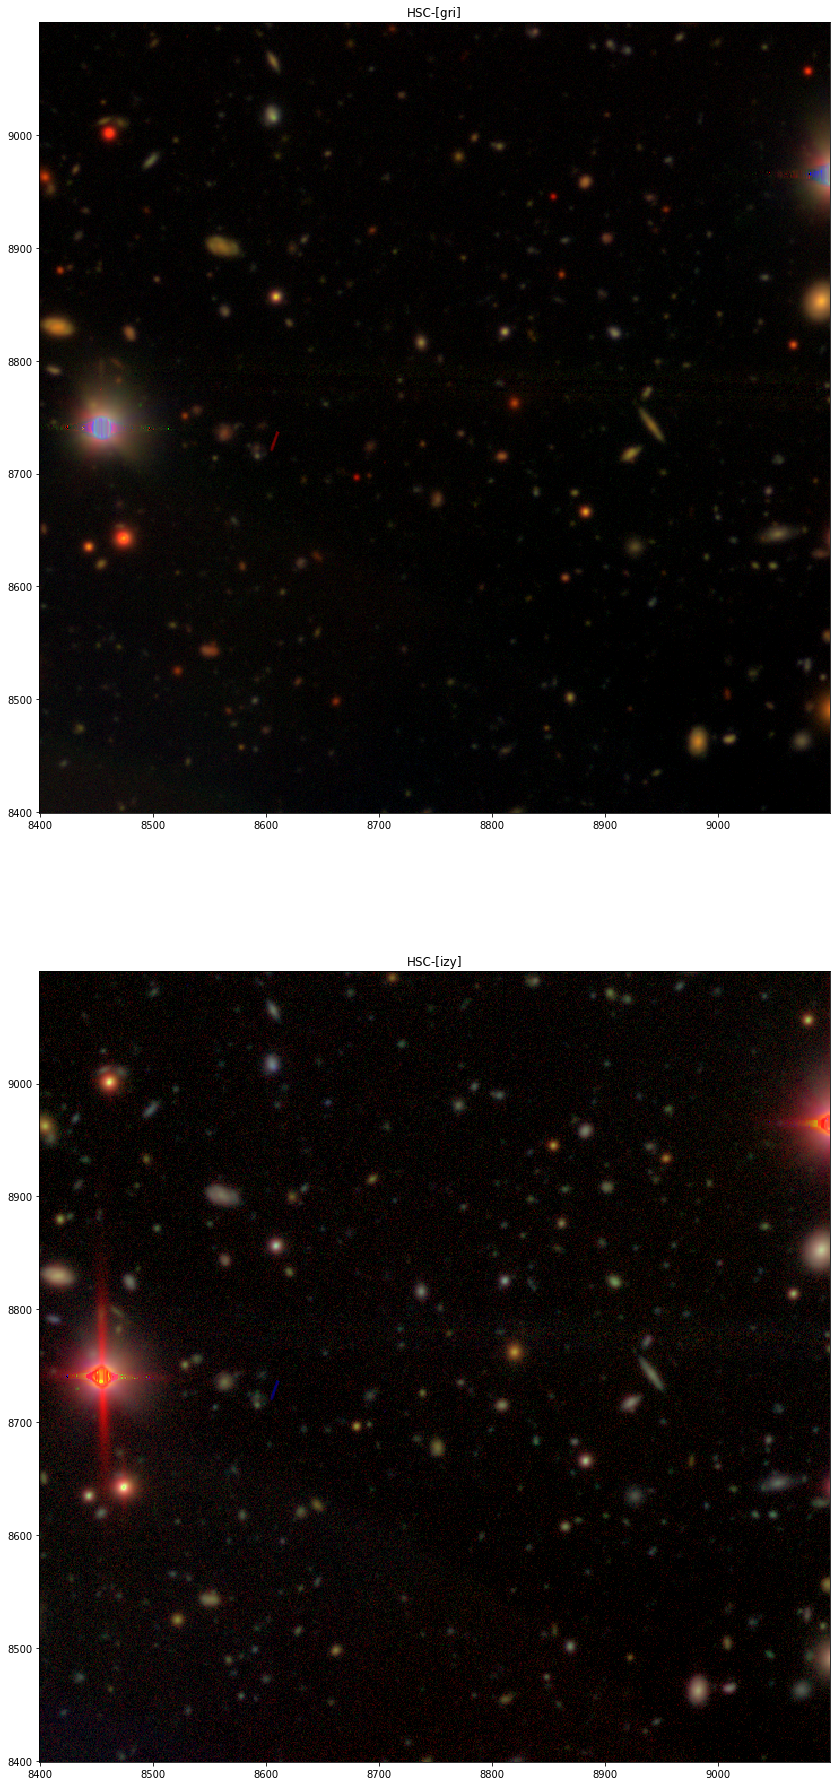

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(16, 32))
axes[0].set_title('HSC-[gri]')
showRGB(coadds[:"z"].image, ax=axes[0])
axes[1].set_title('HSC-[izy]')
showRGB(coadds["i":].image, ax=axes[1])

## Load catalogs

In [6]:
bands = ['HSC-G', 'HSC-R', 'HSC-I']
catsMeas = {f: butlerBase.get("deepCoadd_meas", dataId, filter=f) for f in bands}
catsScarlet = {key: {f: butler.get("deepCoadd_meas", dataId, filter=f) for f in bands} for key, butler in butlersScarlet.items()}
blendsScarlet = {key: {f: butler.get("deepCoadd_deblendedModel", dataId, filter=f) for f in bands} for key, butler in butlersScarlet.items()}

## Match deblended sources and plot

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in log10
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log10
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in log10
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in log10
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/si

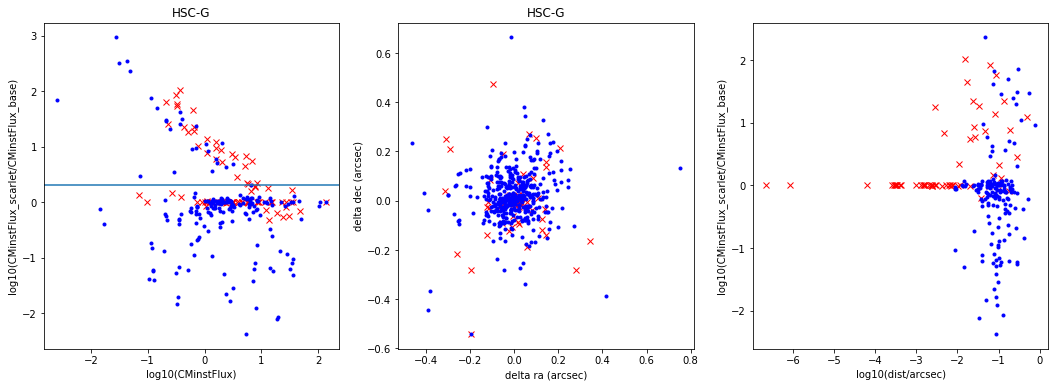

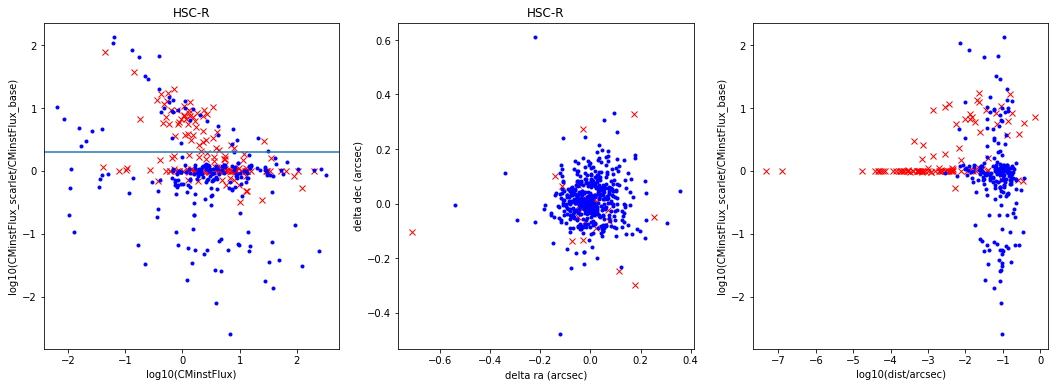

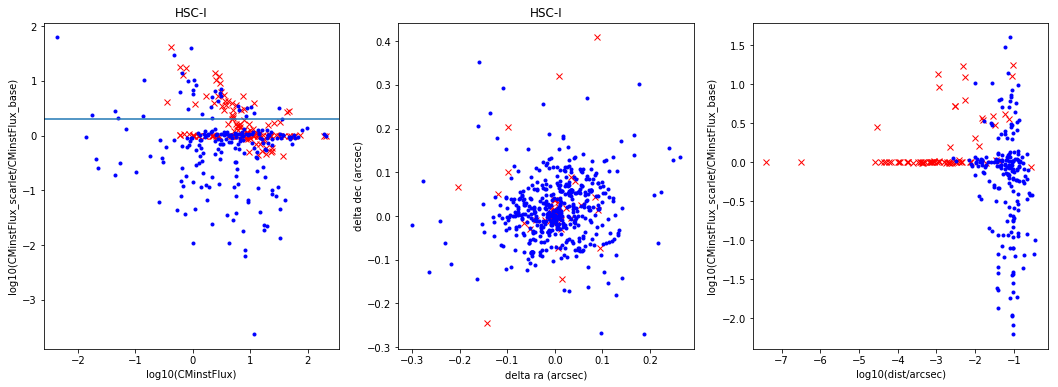

In [7]:
#print(catsMeas[bands[0]].schema)
#print(catsScarlet['noSym'][bands[0]].schema)
bandref = 'HSC-R'
cut_dflux = 0.3
fluxName = 'modelfit_CModel_instFlux'
dfsBase = {key: cat.asAstropy().to_pandas() for key, cat in catsMeas.items()}
for typeScarlet, cats in catsScarlet.items():
    dfsScarlet = {key: cat.asAstropy().to_pandas() for key, cat in cats.items()}
    for band in bands:
        blends = blendsScarlet[typeScarlet][band]
        childIds = {}
        for idx, record in enumerate(catsMeas[band]):
            parent = record["parent"]
            if parent != 0:
                if parent not in childIds:
                    childIds[parent] = []
                childIds[parent].append(record['id'])
        dfScarlet = dfsScarlet[band]
        dfScarlet.columns = 'scarlet_' + dfScarlet.columns
        childIdCounts = {parent: 0 for parent in childIds}
        idsBase = np.zeros(len(blends), dtype=int)
        for idx, record in enumerate(blends):
            parent = record["parent"]
            if parent == 0:
                idsBase[idx] = record["id"]
            else:
                idBase = childIds[parent][childIdCounts[parent]]
                idsBase[idx] = idBase
                childIdCounts[parent] += 1
        dfScarlet['id'] = idsBase
        df = dfScarlet.merge(dfsBase[band], on="id", how="outer")
        dradec = {c: (df['coord_' + c] - df['scarlet_coord_' + c])*180/np.pi*3600 for c in ['ra', 'dec']}
        dist = np.sqrt(dradec['ra']**2 + dradec['dec']**2)
        dflux = np.log10(df['scarlet_' + fluxName]/df[fluxName])
        isolated = df['parent'] == 0
        if band == bandref:
            outliers = (dflux > cut_dflux) & ~isolated
        label_dflux = 'log10(CMinstFlux_scarlet/CMinstFlux_base)'
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].plot(np.log10(df[isolated][fluxName]), dflux[isolated], 'rx')
        axes[0].plot(np.log10(df[~isolated][fluxName]), dflux[~isolated], 'b.')
        axes[0].axhline(cut_dflux)
        axes[0].set(xlabel='log10(CMinstFlux)', ylabel=label_dflux, title=band)
        axes[1].plot(dradec['ra'][isolated], dradec['dec'][isolated], 'rx')
        axes[1].plot(dradec['ra'][~isolated], dradec['dec'][~isolated], 'b.')
        axes[1].set(xlabel='delta ra (arcsec)', ylabel='delta dec (arcsec)', title=band)
        axes[2].plot(np.log10(dist[isolated]), dflux[isolated], 'rx')
        axes[2].plot(np.log10(dist[~isolated]), dflux[~isolated], 'b.')
        axes[2].set(xlabel='log10(dist/arcsec)', ylabel='log10(CMinstFlux_scarlet/CMinstFlux_base)')

0
/project/sr525/hstCosmosImages/tiles/acs_I_030mas_038_sci.fits

44
/project/sr525/hstCosmosImages/tiles/acs_I_030mas_038_sci.fits

parent 43160439890116713 failed: Index 2 not in range [-2, 1]
55
/project/sr525/hstCosmosImages/tiles/acs_I_030mas_038_sci.fits

84
/project/sr525/hstCosmosImages/tiles/acs_I_030mas_038_sci.fits

91
/project/sr525/hstCosmosImages/tiles/acs_I_030mas_038_sci.fits

96
/project/sr525/hstCosmosImages/tiles/acs_I_030mas_038_sci.fits

136
/project/sr525/hstCosmosImages/tiles/acs_I_030mas_038_sci.fits

parent 43160439890116921 failed: Index 2 not in range [-2, 1]
170
/project/sr525/hstCosmosImages/tiles/acs_I_030mas_038_sci.fits

parent 43160439890116999 failed: Index 2 not in range [-2, 1]


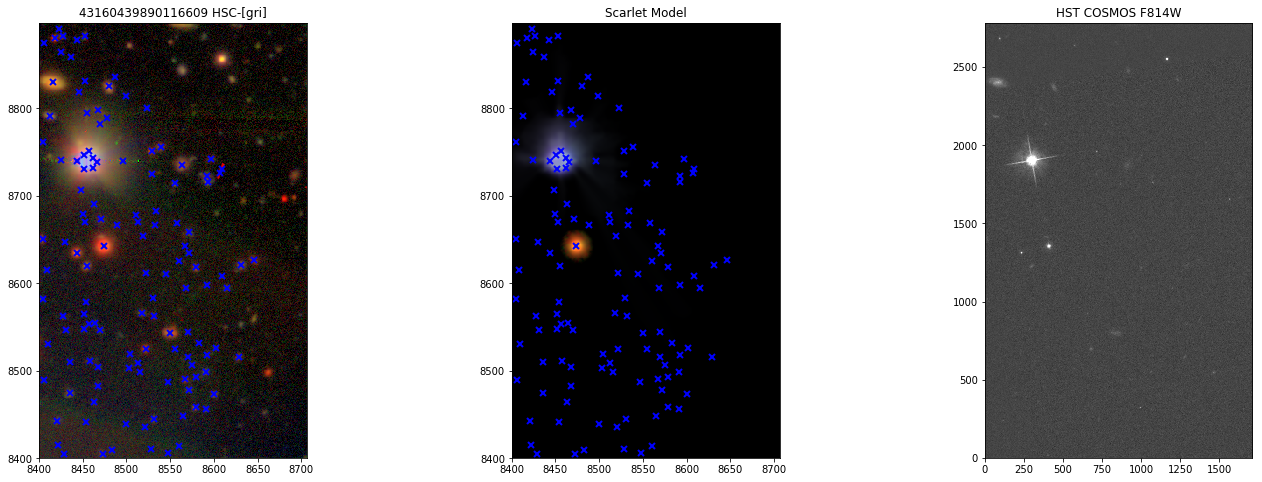

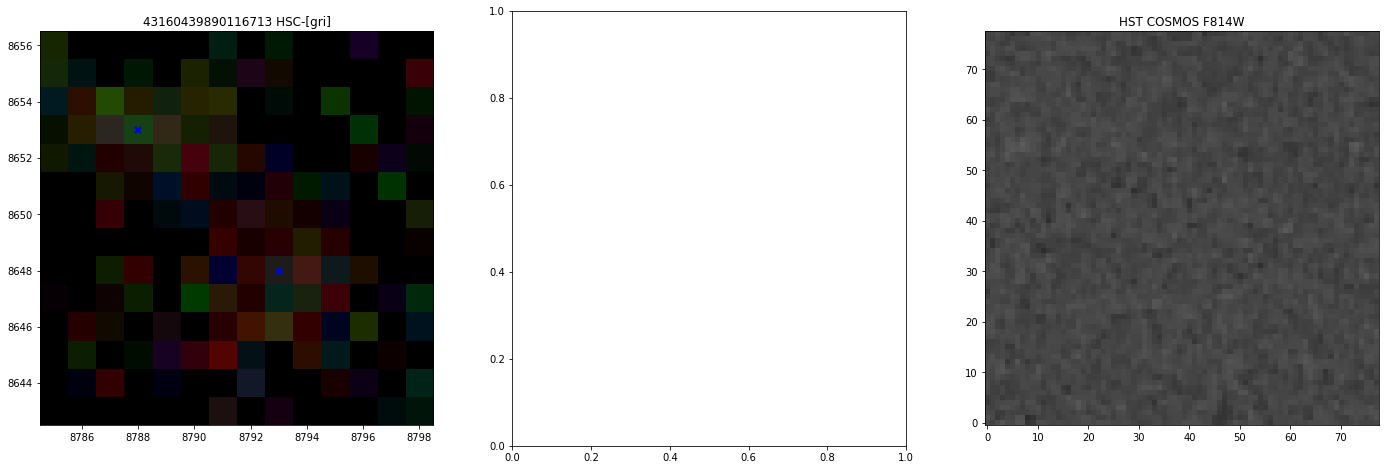

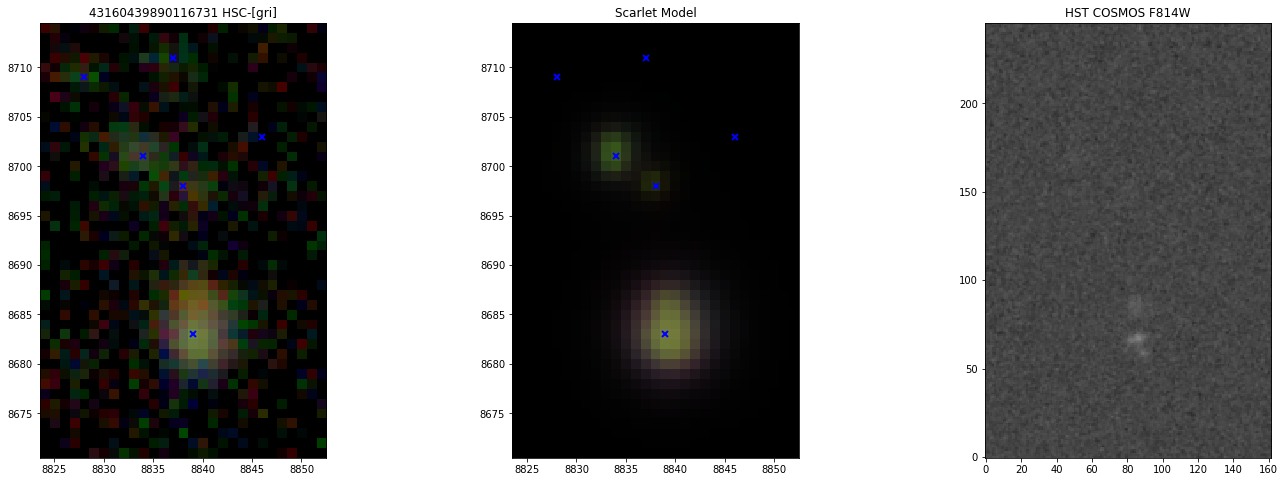

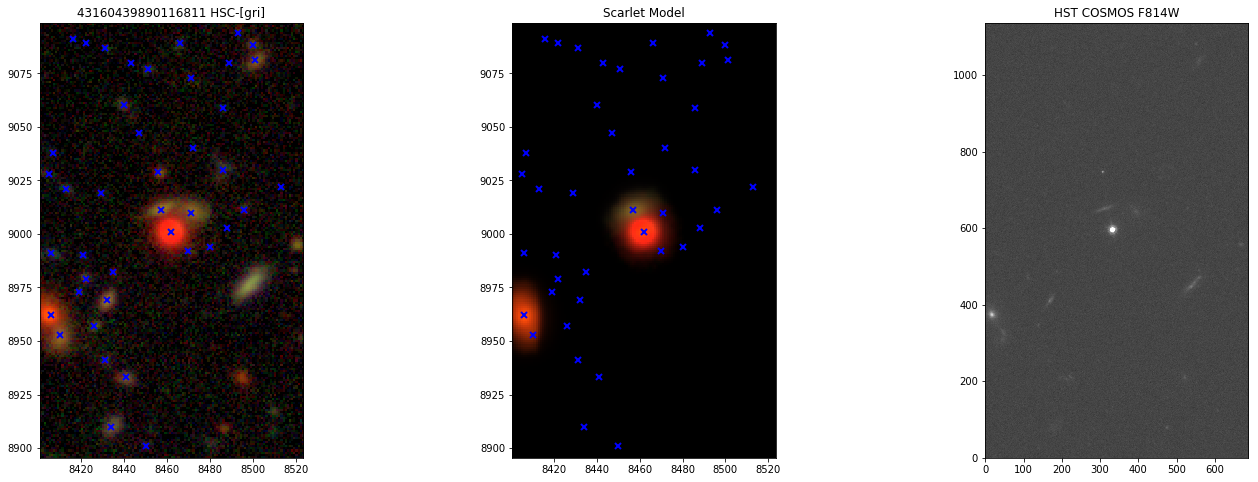

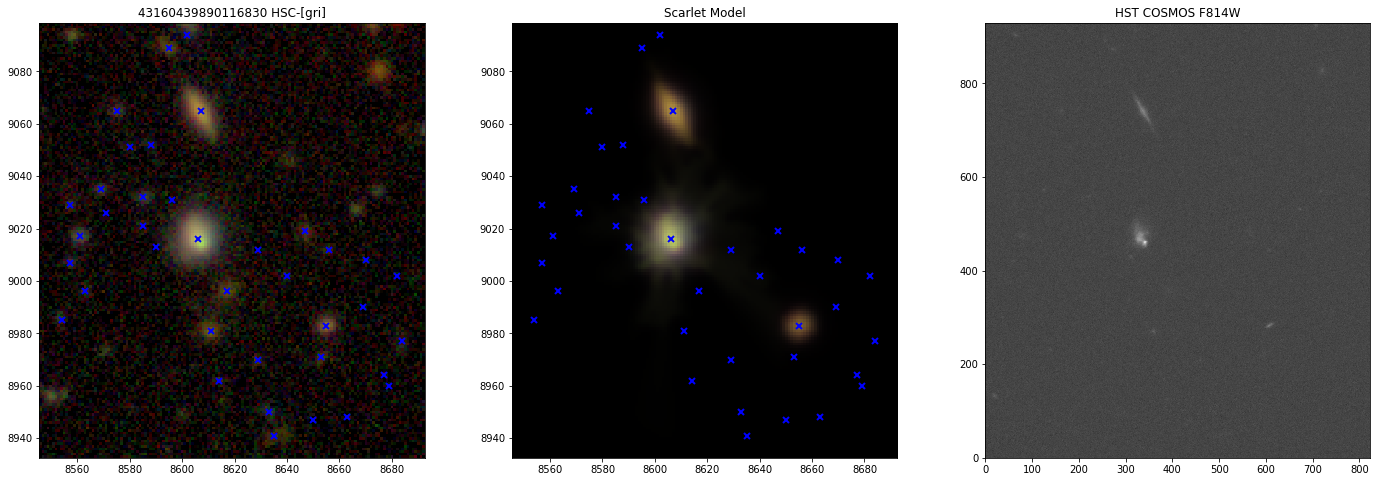

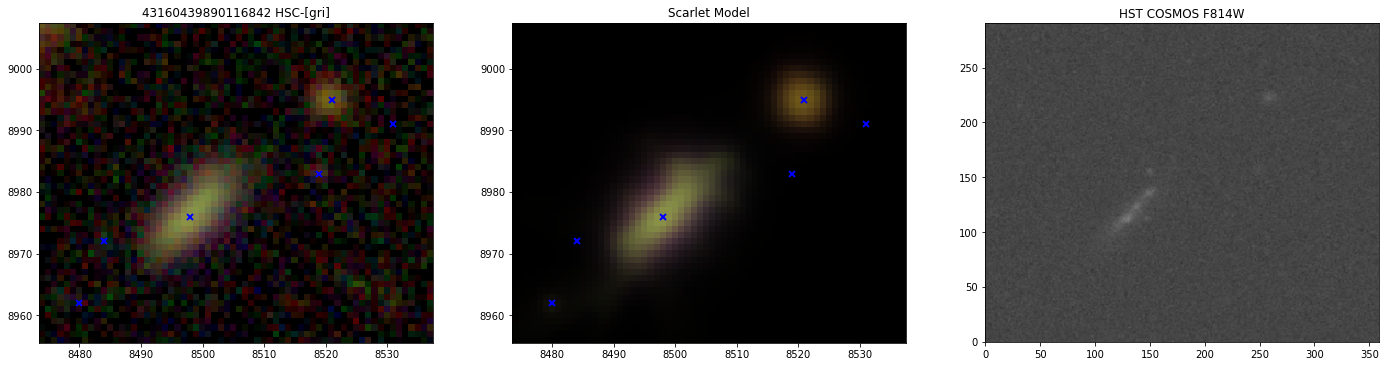

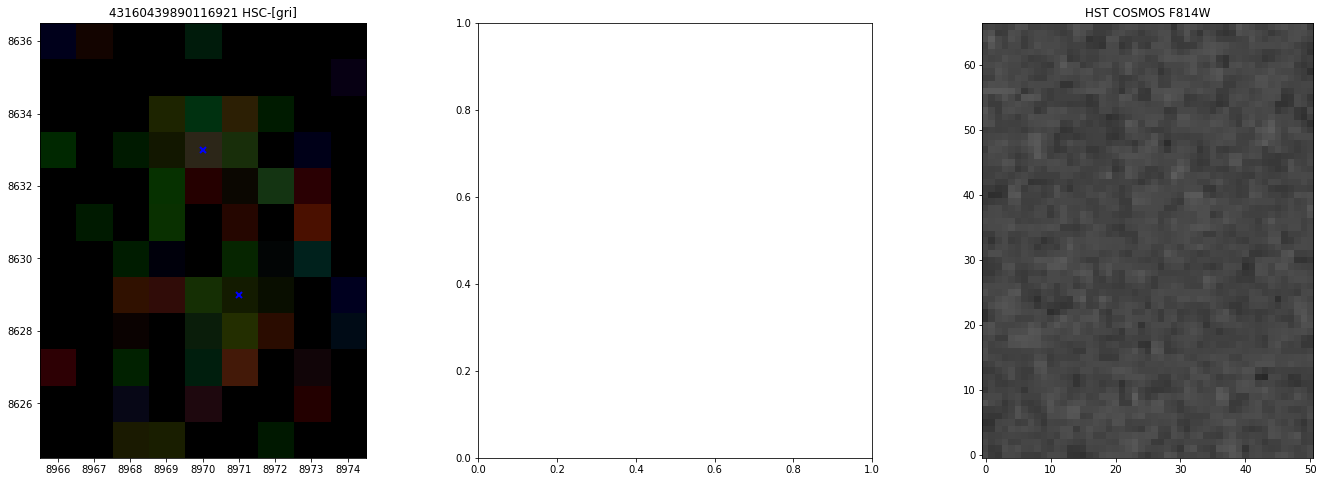

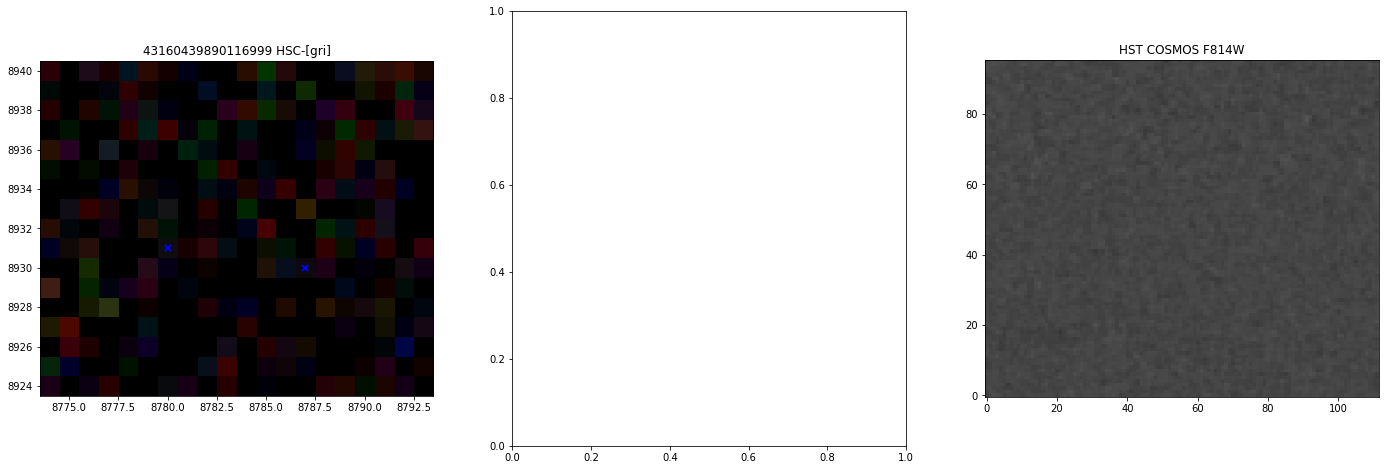

In [8]:
wcs = skymap[tract].getWcs()
for typeScarlet, blends in blendsScarlet.items():
    blendref = blends[bandref]
    parents = np.unique(blendref['parent'][np.where(outliers)[0]])
    for parent in parents:
        outlier = int(np.where(blendref['id'] == parent)[0])
        print(outlier)
        #footprint = MultibandFootprint(bands, [result[b][parentIdx].getFootprint() for b in filters])
        footprint = blendref[outlier].getFootprint()
        bbox = footprint.getBBox()
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))
        showRGB(coadds[:"z", bbox].image, ax=axes[0], stretch=0.25, fp=footprint)
        axes[0].set_title('{} HSC-[gri]'.format(parent))
        ra, dec = wcs.pixelToSky(bbox.getCenter())
        #spherePoint = SpherePoint(ra, dec, degrees)
        img_hst = cutout_HST(ra.asDegrees(), dec.asDegrees(),
                            width=bbox.getWidth()*0.168, height=bbox.getHeight()*0.168,
                            return_data=True)[0][0][1].data
        norm = ImageNormalize(img_hst, stretch=AsinhStretch(a=1/10), vmin=-0.04, vmax=0.4)
        axes[2].imshow(img_hst, interpolation='nearest', origin='bottom', cmap='gray', norm=norm)
        axes[2].set_title('HST COSMOS F814W')
        fullModel = MultibandImage.fromImages(bands, [Image(bbox, dtype=np.float32) for b in range(len(bands))])
        try:
            children = {b: blends[b][blends[b].get("parent")==parent] for b in bands}
            for n in range(len(children)):
                # Add the source model to the model of the entire scene
                fp = MultibandFootprint(bands, [children[b][n].getFootprint() for b in bands])
                fullModel[:, fp.getBBox()].array += fp.getImage(fill=0).image.array
            showRGB(fullModel, ax=axes[1], stretch=0.25, fp=footprint)
            axes[1].set_title('Scarlet Model')
        except Exception as e:
            print('parent {} failed:'.format(parent), e)